# Importación de librerías necesarias para el manejo de directorios y ficheros



In [1]:
import os
import zipfile
import csv
import io

# Declaración de funciones

In [1]:
# Función que verifica si un vehículo es turismo o no
def turismo(line):
    return (line[91:93] == '40')

# Función que extrae la data relevante de cada registro
def procesa_registro(line):
    fecha = line[0:8]
    marca = line[17:46].strip()
    modelo = line[47:68].strip()
    propulsion = line[93:94]
    electrico = line[453:457].strip()
    registro = [fecha, marca, modelo, propulsion, electrico]
    return registro

# Recopilación y depuración de datos

In [5]:
# Inicialización de variables

source_dir = 'data/source'
input_file_encoding = 'ANSI'
target_file_name = 'data/historico_matriculas.csv'
target_file_encoding = 'UTF-8'

# Inicialización de fichero de salida

with open(target_file_name,'w', 
          encoding=target_file_encoding, 
          newline=''
          ) as target_file:
    writer = csv.writer(target_file)

    # Se toma cada fichero zip del directorio fuente

    with os.scandir(source_dir) as source_files:
        for source_zip in source_files:

            # Se toma cada fichero que exista dentro del zip

            with zipfile.ZipFile(source_zip) as zip_file:
                    for input_file_name in zip_file.namelist():

                        # Se procesa cada fichero 

                        with zip_file.open(input_file_name) as input_file:
                            for line in io.TextIOWrapper(input_file, input_file_encoding):

                                # Si el vehículo es un turismo, lo depura y procesa
                                if (turismo(line)):
                                    writer.writerow(procesa_registro(line))

# Transformación de datos

In [2]:
import pandas as pd

data_source_file = 'data/historico_matriculas.csv'
headers = ['fecha', 'marca', 'modelo', 'propulsion', 'electrico']
dtypes = {'fecha': 'str'}

# Carga de los datos en un Dataframe
data = pd.read_csv(data_source_file, header=None, names=headers, dtype = dtypes, na_filter = False)
data.head(10)


fecha       marca        modelo propulsion electrico
0  02012015  VOLKSWAGEN        TIGUAN          1          
1  02012015  VOLKSWAGEN        TIGUAN          1          
2  02012015       LEXUS  LEXUS GS300H          0       HEV
3  02012015         BMW  X3 XDRIVE20D          1          
4  02012015        AUDI  A1 SPORTBACK          1          
5  02012015  VOLKSWAGEN            UP          0          
6  02012015     HYUNDAI           I10          0          
7  02012015  VOLKSWAGEN          POLO          1          
8  02012015      TOYOTA   TOYOTA RAV4          1          
9  02012015     RENAULT          CLIO          1

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8167155 entries, 0 to 8167154
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   fecha       object
 1   marca       object
 2   modelo      object
 3   propulsion  object
 4   electrico   object
dtypes: object(5)
memory usage: 311.6+ MB


In [102]:
data.describe()

fecha    marca   modelo propulsion electrico
count    8167155  8167155  8167155    8167155   8167155
unique      1820      838    57392         17         9
top     30112018  PEUGEOT  SANDERO          0          
freq       29481   673534   181277    4346457   7486859

In [103]:
# Se verifica la presencia de valores nulos

data.isna().any()

fecha         False
marca         False
modelo        False
propulsion    False
electrico     False
dtype: bool

In [3]:
# Transformar el campo fecha de str a Datetime

data['fecha'] = pd.to_datetime(data['fecha'], format='%d%m%Y')
data.head()

fecha       marca        modelo propulsion electrico
0 2015-01-02  VOLKSWAGEN        TIGUAN          1          
1 2015-01-02  VOLKSWAGEN        TIGUAN          1          
2 2015-01-02       LEXUS  LEXUS GS300H          0       HEV
3 2015-01-02         BMW  X3 XDRIVE20D          1          
4 2015-01-02        AUDI  A1 SPORTBACK          1

In [4]:
# Verificar registros anteriores a 2015

condicion = data.fecha < '2015-01-01'
data.loc[condicion]

fecha          marca         modelo propulsion electrico
2953437 2007-12-12  MERCEDES-BENZ      A 180 CDI          1          
3225681 2013-03-06            BMW           530D          1          
3808515 1962-04-10           SEAT       SEAT 600          0          
3839651 1934-07-26           M.G.        TORPEDO          0          
3844282 1967-11-02           M.G.           1100          0          
...            ...            ...            ...        ...       ...
7563383 1959-02-23           SEAT           1400          0          
7592412 1955-01-31     VOLKSWAGEN     ESCARABAJO          0          
7620664 1957-12-18           SEAT           1400          0          
7899379 1957-01-01        RENAULT  CUATRO CUATRO          0          
8021605 1965-06-01     VOLKSWAGEN     ESCARABAJO          0          

[97 rows x 5 columns]

In [5]:
# Eliminamos registros anteriores a 2015

data = data.drop(data[condicion].index)
data.loc[condicion]

Empty DataFrame
Columns: [fecha, marca, modelo, propulsion, electrico]
Index: []

In [6]:
# Analizar columna "propulsion"

data.propulsion.value_counts()

0    4346392
1    3643022
2      73480
6      66882
       20565
7      16186
4        171
3        121
9        112
8         79
A         14
B         13
G         13
C          5
5          1
D          1
E          1
Name: propulsion, dtype: int64

In [7]:
# Eliminar registros con propulsion nula

condicion_propulsion = data['propulsion'] == ' '
data = data.drop(data[condicion_propulsion].index)
data.propulsion.value_counts()

0    4346392
1    3643022
2      73480
6      66882
7      16186
4        171
3        121
9        112
8         79
A         14
B         13
G         13
C          5
5          1
D          1
E          1
Name: propulsion, dtype: int64

In [8]:
# Transformar el campo "propulsión"
# 0 - Gasolina
# 1 - Gasoil
# 2 - Híbrido / Eléctrico
# 3 - Otros

condicion_electrico = data.electrico != ''

# Híbridos y Eléctricos : valor '2'

data.loc[condicion_electrico, 'propulsion'] = '2' 

# Todo excepto Gasolina, Gasoil e Híbrido/Eléctrico : valor '3'

data.loc[~ data['propulsion'].isin(['0', '1', '2']), 'propulsion'] = '3'

data.head(10)

fecha       marca        modelo propulsion electrico
0 2015-01-02  VOLKSWAGEN        TIGUAN          1          
1 2015-01-02  VOLKSWAGEN        TIGUAN          1          
2 2015-01-02       LEXUS  LEXUS GS300H          2       HEV
3 2015-01-02         BMW  X3 XDRIVE20D          1          
4 2015-01-02        AUDI  A1 SPORTBACK          1          
5 2015-01-02  VOLKSWAGEN            UP          0          
6 2015-01-02     HYUNDAI           I10          0          
7 2015-01-02  VOLKSWAGEN          POLO          1          
8 2015-01-02      TOYOTA   TOYOTA RAV4          1          
9 2015-01-02     RENAULT          CLIO          1

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8167058 entries, 0 to 8167154
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   fecha       datetime64[ns]
 1   marca       object        
 2   modelo      object        
 3   propulsion  int8          
 4   electrico   object        
dtypes: datetime64[ns](1), int8(1), object(3)
memory usage: 319.3+ MB


In [9]:
# Transformar columna "propulsión" a entero

data['propulsion'] = data['propulsion'].astype('int8')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8146493 entries, 0 to 8167154
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   fecha       datetime64[ns]
 1   marca       object        
 2   modelo      object        
 3   propulsion  int8          
 4   electrico   object        
dtypes: datetime64[ns](1), int8(1), object(3)
memory usage: 318.5+ MB


In [10]:
# Guardar los datos ya depurados y transformados

depured_file = 'data/historico_matriculas_depurado.csv'
data.to_csv(depured_file, index=False)
data

fecha       marca                 modelo  propulsion electrico
0       2015-01-02  VOLKSWAGEN                 TIGUAN           1          
1       2015-01-02  VOLKSWAGEN                 TIGUAN           1          
2       2015-01-02       LEXUS           LEXUS GS300H           2       HEV
3       2015-01-02         BMW           X3 XDRIVE20D           1          
4       2015-01-02        AUDI           A1 SPORTBACK           1          
...            ...         ...                    ...         ...       ...
8167150 2021-09-30       DACIA                SANDERO           0          
8167151 2021-09-30  VOLKSWAGEN                  T-ROC           0          
8167152 2021-09-30        OPEL  CORSA EDITION  1.5D D           1          
8167153 2021-09-30  VOLKSWAGEN                  CADDY           1          
8167154 2021-09-30        FIAT                  PANDA           2       HEV

[8146493 rows x 5 columns]

In [1]:
# Carga el archivo depurado en un Dataframe

import pandas as pd

depured_file = 'data/historico_matriculas_depurado.csv'
dtypes = {'propulsion' : 'int8'}


data = pd.read_csv(depured_file, dtype=dtypes, parse_dates=['fecha'], na_filter = False)
data.head(10)


fecha       marca        modelo  propulsion electrico
0 2015-01-02  VOLKSWAGEN        TIGUAN           1          
1 2015-01-02  VOLKSWAGEN        TIGUAN           1          
2 2015-01-02       LEXUS  LEXUS GS300H           2       HEV
3 2015-01-02         BMW  X3 XDRIVE20D           1          
4 2015-01-02        AUDI  A1 SPORTBACK           1          
5 2015-01-02  VOLKSWAGEN            UP           0          
6 2015-01-02     HYUNDAI           I10           0          
7 2015-01-02  VOLKSWAGEN          POLO           1          
8 2015-01-02      TOYOTA   TOYOTA RAV4           1          
9 2015-01-02     RENAULT          CLIO           1

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8167058 entries, 0 to 8167057
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   fecha       datetime64[ns]
 1   marca       object        
 2   modelo      object        
 3   propulsion  int8          
 4   electrico   object        
dtypes: datetime64[ns](1), int8(1), object(3)
memory usage: 257.0+ MB


# Construcción de gráfica de Ventas de Turismo

In [2]:
# Damos valor a los datos de la columna "propulsion"

data['propulsion'] = data['propulsion'].replace([0, 1, 2, 3],['Gasolina', 'Gasoil', 'Híbrido / Eléctrico', 'Otros'])

In [3]:
# Agrupamos por tipo de propulsión y fecha

e = data.groupby(['propulsion', data.fecha.map(lambda x: x.year)])

In [4]:
e.size().unstack(0).fillna(0)

propulsion  Gasoil  Gasolina  Híbrido / Eléctrico  Otros
fecha                                                   
2015        693137    388364                 9910   2718
2016        719310    484359                33669   1757
2017        683624    597908                63097   5249
2018        552386    766523                87700  22083
2019        436544    789111               122557  27193
2020        313331    444788               171356  13589
2021        189552    323260               192631  10787

<AxesSubplot:title={'center':'Ventas Turismos - España'}>

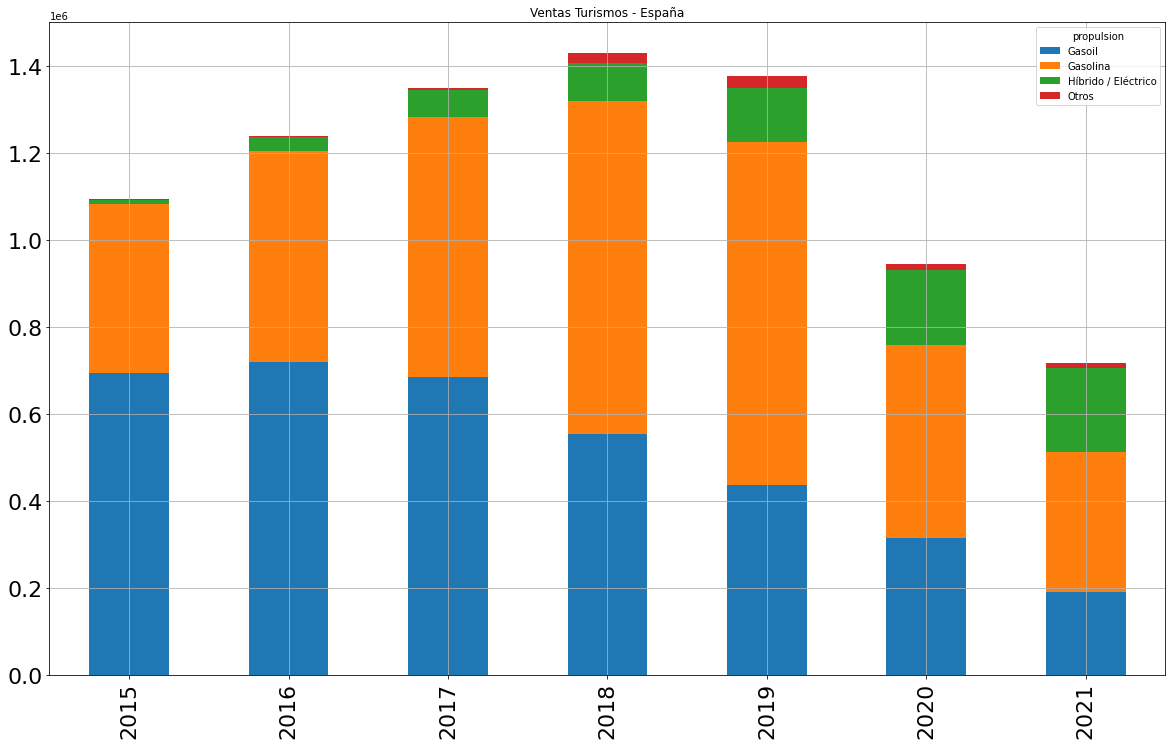

In [21]:
# Lanzamiento de la gráfica

tabla = e.size().unstack(0).fillna(0)

tabla.plot(kind='bar', 
                                   figsize = (20,12), 
                                   stacked = True,
                                   title = 'Ventas Turismos - España', 
                                   # xlim=(2015, 2022),
                                   grid = True,
                                   xlabel = '', 
                                   ylabel = '', 
                                   fontsize = 22)



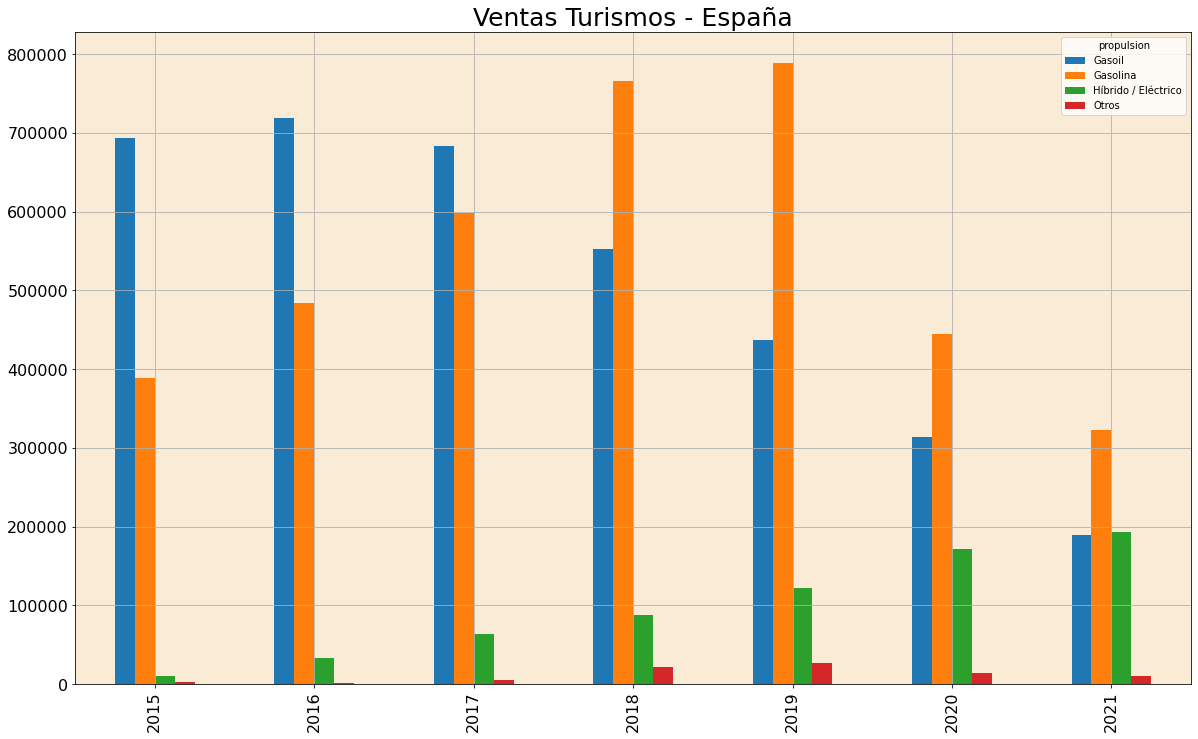

In [39]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
ax = tabla.plot(kind='bar', 
                                   figsize = (20,12), 
                                   # stacked = True,
                                   # title = 'Ventas Turismos - España', 
                                   # xlim=(2015, 2022),
                                   grid = True,
                                   xlabel = '', 
                                   ylabel = '', 
                                   fontsize = 22)
ax.set_facecolor('#FAEBD7')
ax.set_title('Ventas Turismos - España', size=25)
ax.tick_params(labelsize=16) # Tamaño de los ticks
# ax.set_xticklabels(e.index(), rotation=0)


In [18]:
grafica = e.size().unstack(0).fillna(0)
grafica

propulsion  Gasoil  Gasolina  Híbrido / Eléctrico  Otros
fecha                                                   
2015        693137    388364                 9910   2718
2016        719310    484359                33669   1757
2017        683624    597908                63097   5249
2018        552386    766523                87700  22083
2019        436544    789111               122557  27193
2020        313331    444788               171356  13589
2021        189552    323260               192631  10787

# Misma gráfica usando pyplot orientado a objetos

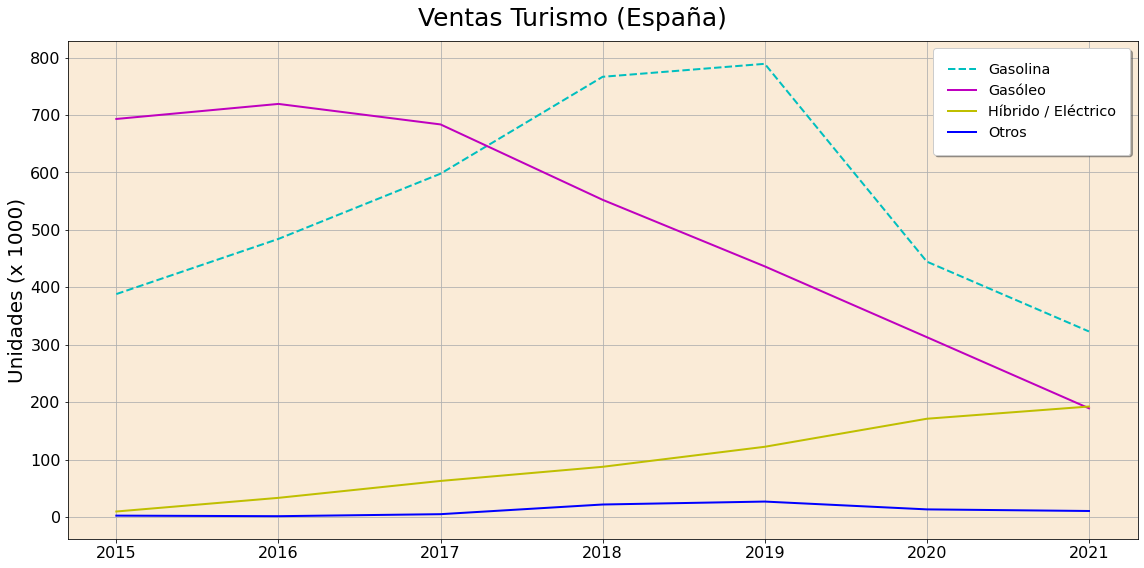

In [19]:
import matplotlib.pyplot as plt

grafica = e.size().unstack(0).fillna(0)

eje_x = grafica.index

eje_y1 = grafica.Gasolina
eje_y2 = grafica.Gasoil
eje_y3 = grafica['Híbrido / Eléctrico']
eje_y4 = grafica.Otros

# plt.style.use('ggplot')

fig,ax = plt.subplots(figsize=(16,8))

ax.set_facecolor('#FAEBD7')

plt.plot(eje_x, eje_y1/1000, 'c--', lw=2, label = 'Gasolina')
plt.plot(eje_x, eje_y2/1000, 'm-', lw=2, label = 'Gasóleo')
plt.plot(eje_x, eje_y3/1000, 'y-', lw=2, label = 'Híbrido / Eléctrico')
plt.plot(eje_x, eje_y4/1000, 'b-', lw=2, label = 'Otros')

plt.legend(loc='upper right', fontsize = 'x-large', facecolor = 'white', fancybox=True, framealpha=1, shadow=True, borderpad=1)

plt.suptitle('Ventas Turismo (España)', size=25)

# plt.xlabel('Años', size=20)
plt.ylabel('Unidades (x 1000)', size = 20)

# plt.ylim(0.6, 1.8)

plt.grid(True)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.tight_layout()

plt.show()

# Misma gráfica variando la frecuencia a trimestral

In [3]:
data['trimestre'] = data['fecha'].dt.to_period('Q')
e = data.groupby(['propulsion', 'trimestre'])

grafica = e.size().unstack(0).fillna(0)
grafica


propulsion  Gasoil  Gasolina  Híbrido / Eléctrico  Otros
trimestre                                               
2015Q1      180544     95247                 1765    657
2015Q2      188922    109118                 2103    984
2015Q3      157173     85181                 3054    576
2015Q4      166498     98818                 2988    501
2016Q1      182235    116838                 7062    435
2016Q2      206397    145988                 8255    692
2016Q3      159140    105822                 8228    296
2016Q4      171538    115711                10124    334
2017Q1      179159    142791                13702    594
2017Q2      196999    175016                15723    957
2017Q3      149912    126488                15785   1331
2017Q4      157554    153613                17887   2367
2018Q1      151962    195112                18989   3234
2018Q2      163709    229742                23878   6311
2018Q3      129981    173382                21400   6313
2018Q4      106734    168287                23433   6225
2019Q1      109820    202253                26747   6251
2019Q2      124517    242083                31900   8714
2019Q3       93840    170212                27864   7970
2019Q4      108367    174563                36046   4258
2020Q1       79046    125419                35425   2501
2020Q2       46133     65707                19048   1602
2020Q3       92989    136720                48863   4563
2020Q4       95163    116942                68020   4923
2021Q1       60474     95150                48913   2663
2021Q2       73365    136534                80250   3248
2021Q3       55713     91576                63468   4876

In [4]:
grafica.index

PeriodIndex(['2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
             '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4',
             '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2',
             '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4',
             '2021Q1', '2021Q2', '2021Q3'],
            dtype='period[Q-DEC]', name='trimestre')

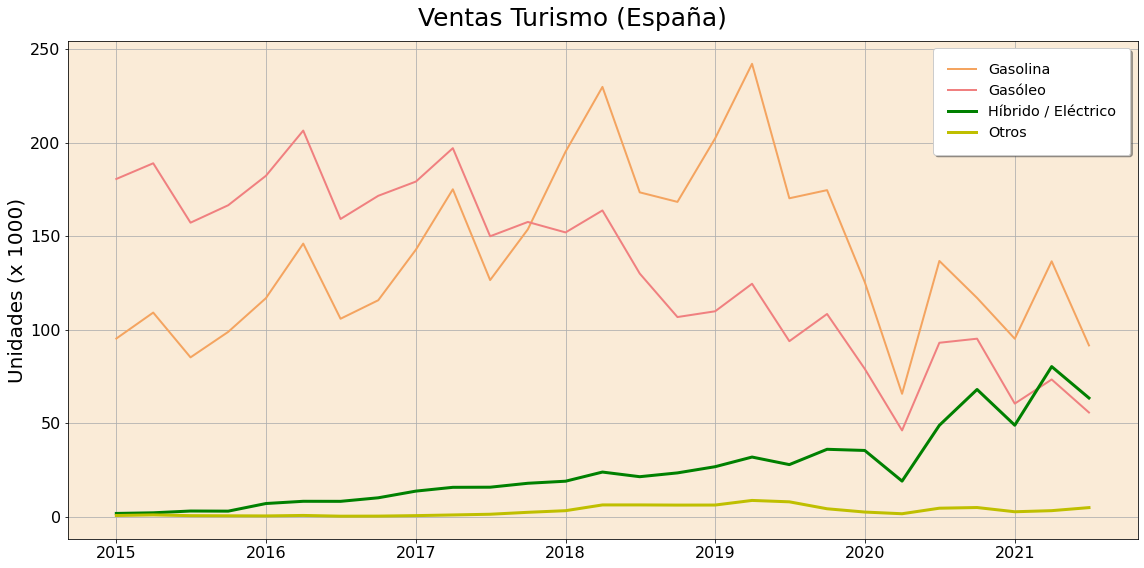

In [6]:
# grafica = e.size().unstack(0).fillna(0)

import matplotlib.pyplot as plt

eje_x = grafica.index.astype('datetime64[ns]')

eje_y1 = grafica.Gasolina
eje_y2 = grafica.Gasoil
eje_y3 = grafica['Híbrido / Eléctrico']
eje_y4 = grafica.Otros

# plt.style.use('ggplot')

fig,ax = plt.subplots(figsize=(16,8))

ax.set_facecolor('#FAEBD7')

plt.plot(eje_x, eje_y1/1000, '-', color = 'sandybrown', lw=2, label = 'Gasolina')
plt.plot(eje_x, eje_y2/1000, '-', color = 'lightcoral', lw=2, label = 'Gasóleo')
plt.plot(eje_x, eje_y3/1000, 'g-', lw=3, label = 'Híbrido / Eléctrico')
plt.plot(eje_x, eje_y4/1000, 'y-', lw=3, label = 'Otros')

plt.legend(loc='upper right', fontsize = 'x-large', facecolor = 'white', fancybox=True, framealpha=1, shadow=True, borderpad=1)

plt.suptitle('Ventas Turismo (España)', size=25)

# plt.xlabel('Años', size=20)
plt.ylabel('Unidades (x 1000)', size = 20)

# plt.ylim(0.6, 1.8)

plt.grid(True)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.tight_layout()

plt.show()

# Gráfica de torta Ventas año 2021

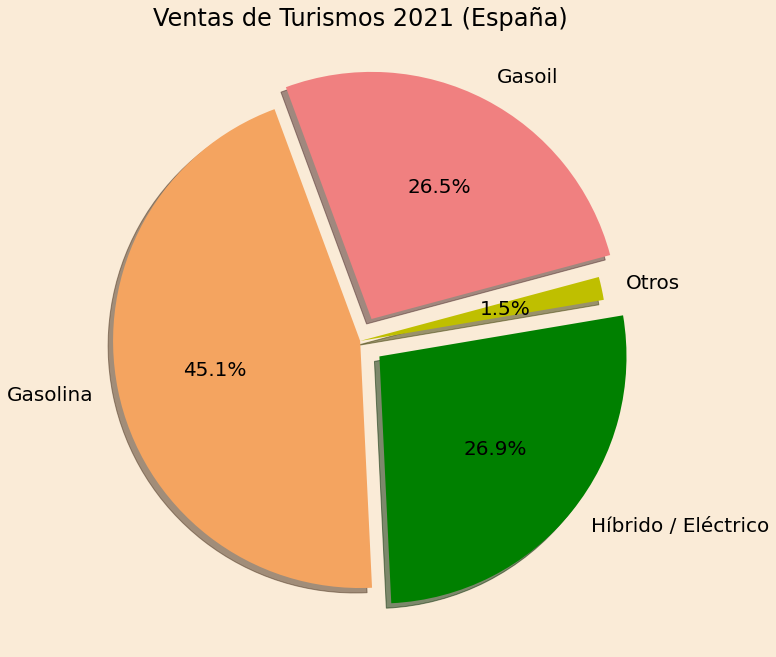

In [77]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np

condicion = data.fecha > '31-12-2020'

e = data[condicion].groupby('propulsion')

fig = plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)

fig.set_facecolor('#FAEBD7')

colors = ["c", 'g','m','y','g']
colors = ["lightcoral", 'sandybrown','g','y','g']
my_explode = (0.1, 0, 0.1, 0)
labels = e.size().index

plt.subplot(the_grid[0, 1], aspect=1)

plt.title('Ventas de Turismos 2021 (España)', fontsize = 24)

type_show_ids = plt.pie(e.size().values, 
                        labels=labels, 
                        startangle=15, 
                        autopct='%1.1f%%', 
                        shadow=True, 
                        colors=colors, 
                        explode=my_explode,
                        textprops={'fontsize': 20})
plt.rc('axes', titlesize=24)


# plt.legend(loc='lower left')                        
plt.show()

In [23]:
condicion = ((data.fecha > '31-12-2020') & (data.propulsion == 'Híbrido / Eléctrico'))
electricos = data[condicion].groupby('electrico')
electricos.size().values

array([    29,  15598,      6, 151361,  25545,     92], dtype=int64)

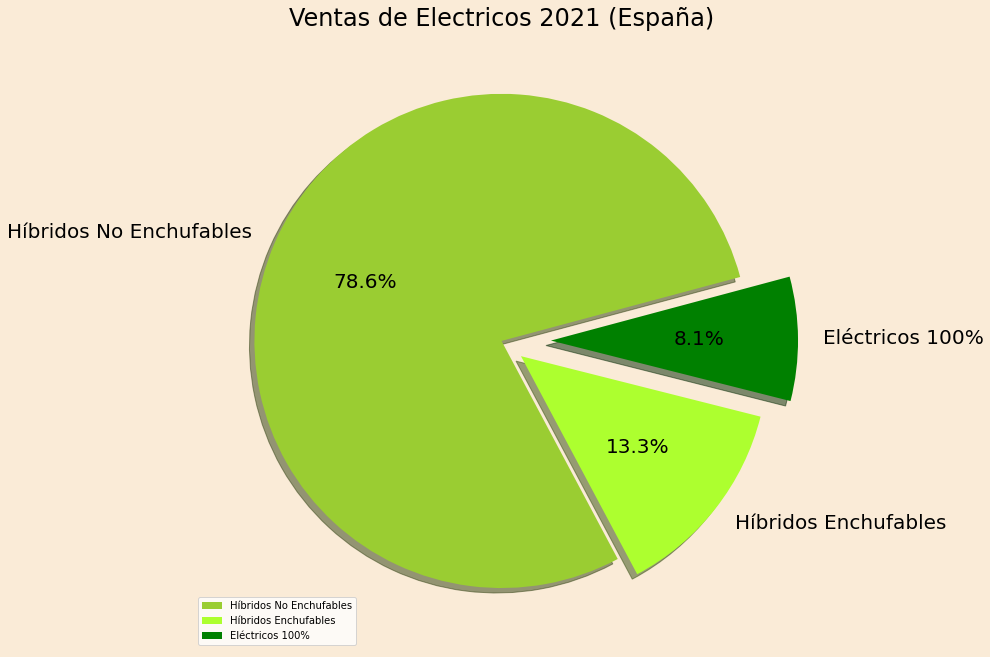

In [92]:
condicion = ((data.fecha > '31-12-2020') & (data.propulsion == 'Híbrido / Eléctrico'))
electricos = data[condicion].groupby('electrico')
electricos = electricos.size().sort_values(ascending=False)[:3]

data['propulsion'] = data['propulsion'].replace([0, 1, 2, 3],['Gasolina', 'Gasoil', 'Híbrido / Eléctrico', 'Otros'])

fig = plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)

fig.set_facecolor('#FAEBD7')

labels = ['Híbridos No Enchufables', 'Híbridos Enchufables', 'Eléctricos 100%']
colors = ['yellowgreen', 'greenyellow', 'g']
my_explode = (0, 0.1, 0.2)

plt.subplot(the_grid[0, 1], aspect=1, title='Ventas de Electricos 2021')

plt.title('Ventas de Electricos 2021 (España)', fontsize = 24)

type_show_ids = plt.pie(electricos.values, 
                        startangle=15, 
                        labels = labels,
                        explode=my_explode, 
                        autopct='%1.1f%%', shadow=True, colors=colors, textprops={'fontsize': 20})
plt.legend(loc='lower left')
plt.show()



In [169]:
electricos.size().index

Index(['', 'BEV', 'FCEV', 'HEV', 'PHEV', 'REEV'], dtype='object', name='electrico')